In [0]:
from google.colab import drive
drive.mount('/content/drive')
#!ls drive/My\ Drive

In [0]:
#!pip3 install torch
#!pip3 install torchvision

In [0]:
#!tar -xvf "/content/drive/My Drive/VOCtrainval_06-Nov-2007.tar"

In [0]:
#import os
#os.listdir("/content/VOCdevkit/VOC2007/")

In [1]:
import os

def get_idx_name(path):
  idx = os.listdir(path)
  idx_name = []
  for i in range(len(idx)):
    idx_name.append(os.path.splitext(idx[i])[0])
  return idx_name


img_path = "/content/VOCdevkit/VOC2007/JPEGImages"
mask_path = "/content/VOCdevkit/VOC2007/SegmentationObject"

img_idx = get_idx_name("/content/VOCdevkit/VOC2007/JPEGImages")
mask_idx = get_idx_name("/content/VOCdevkit/VOC2007/SegmentationObject")
print(len(img_idx), img_idx[:3])
print(len(mask_idx), mask_idx[:3])

5011 ['009022', '000035', '005371']
422 ['001185', '000661', '008670']


In [2]:
img_has_mask_idx = set(img_idx) & set(mask_idx)
img_has_mask_idx = list(img_has_mask_idx)

print(len(img_has_mask_idx), sorted(img_has_mask_idx)[:3])
print(len(mask_idx), sorted(mask_idx)[:3])

422 ['000032', '000033', '000039']
422 ['000032', '000033', '000039']


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

from keras.preprocessing.image import array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
# https://forums.fast.ai/t/attributeerror-module-pil-image-has-no-attribute-register-extensions/10689/2
!pip install --no-cache-dir -I pillow

In [13]:
train_df = pd.DataFrame()
train_df["images"] = [np.array(load_img(img_path + "/{}.jpg".format(idx), color_mode="grayscale")) / 255 for idx in sorted(img_has_mask_idx)]
train_df["masks"] = [np.array(load_img(mask_path + "/{}.png".format(idx), color_mode="grayscale")) / 255 for idx in sorted(mask_idx)]
print(train_df.shape)
train_df.head()

(422, 2)


,images,masks
0,"[[0.6901960784313725, 0.6901960784313725, 0.69...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[[0.8666666666666667, 0.8313725490196079, 0.84...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[[0.6352941176470588, 0.6588235294117647, 0.66...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"[[0.9058823529411765, 0.9019607843137255, 0.90...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,"[[0.9568627450980393, 0.9490196078431372, 0.94...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [14]:
train_df.images[0].shape, train_df.masks[0].shape

((281, 500), (281, 500))

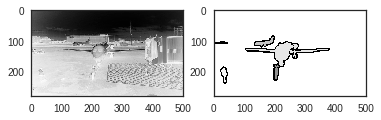

In [15]:
plt.subplot(1, 2, 1)
plt.imshow(train_df.images[0])

plt.subplot(1, 2, 2)
plt.imshow(train_df.masks[0])

In [0]:
from skimage.transform import resize

#img_size_ori = 101
#img_size_target = train_df.images[0].shape[0]

img_size_ori = train_df.images[0].shape[0]
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

**build model ~ predict**

In [82]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
    np.array(train_df.images[1:].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks[1:].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 

    test_size=0.2, random_state= 1234)

# for check
# train_df.images[0] and train_df.masks[0]

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((336, 101, 101, 1), (85, 101, 101, 1), (336, 101, 101, 1), (85, 101, 101, 1))

In [0]:
plt.subplot(1, 4, 1)
plt.imshow(x_train[0].reshape(281, 281))

plt.subplot(1, 4, 2)
plt.imshow(y_train[0].reshape(281, 281))

plt.subplot(1, 4, 3)
plt.imshow(x_valid[0].reshape(281, 281))

plt.subplot(1, 4, 4)
plt.imshow(y_valid[0].reshape(281, 281))

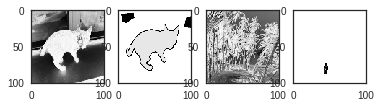

In [83]:
plt.subplot(1, 4, 1)
plt.imshow(x_train[0].reshape(101, 101))

plt.subplot(1, 4, 2)
plt.imshow(y_train[0].reshape(101, 101))

plt.subplot(1, 4, 3)
plt.imshow(x_valid[0].reshape(101, 101))

plt.subplot(1, 4, 4)
plt.imshow(y_valid[0].reshape(101, 101))

In [84]:
x_train_aug = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train_aug = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train_aug.shape)
print(y_valid.shape)

(672, 101, 101, 1)
(85, 101, 101, 1)


**build model**

cf : 

https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks-v2-new-loss


https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63044


In [0]:
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

In [0]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [0]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [0]:
def iou_loss_core(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

In [89]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[iou_loss_core])

model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_118 (Conv2D)             (None, 101, 101, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_116 (BatchN (None, 101, 101, 16) 64          conv2d_118[0][0]                 
__________________________________________________________________________________________________
activation_118 (Activation)     (None, 101, 101, 16) 0           batch_normalization_116[0][0]    
__________________________________________________________________________________________________
conv2d_119

In [90]:
version = 5
basic_name = f'Unet_resnet_v{version}'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v5.model
Unet_resnet_v5.csv


In [98]:
early_stopping = EarlyStopping(monitor='iou_loss_core', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='iou_loss_core', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='iou_loss_core', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 50
batch_size = 16
history = model1.fit(x_train_aug, y_train_aug,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr], 
                    verbose=1)

Train on 672 samples, validate on 85 samples
Epoch 1/50
672/672 [==============================] - 28s 42ms/step - loss: 0.3483 - iou_loss_core: 0.8482 - val_loss: 0.8506 - val_iou_loss_core: 0.8898

Epoch 00001: iou_loss_core improved from -inf to 0.84822, saving model to Unet_resnet_v5.model
Epoch 2/50
672/672 [==============================] - 13s 19ms/step - loss: 0.3067 - iou_loss_core: 0.8708 - val_loss: 0.7102 - val_iou_loss_core: 0.8998

Epoch 00002: iou_loss_core improved from 0.84822 to 0.87077, saving model to Unet_resnet_v5.model
Epoch 3/50
672/672 [==============================] - 13s 19ms/step - loss: 0.3057 - iou_loss_core: 0.8703 - val_loss: 1.9651 - val_iou_loss_core: 0.8966

Epoch 00003: iou_loss_core did not improve from 0.87077
Epoch 4/50
672/672 [==============================] - 13s 19ms/step - loss: 0.3025 - iou_loss_core: 0.8711 - val_loss: 0.8536 - val_iou_loss_core: 0.8881

Epoch 00004: iou_loss_core improved from 0.87077 to 0.87106, saving model to Unet_resn

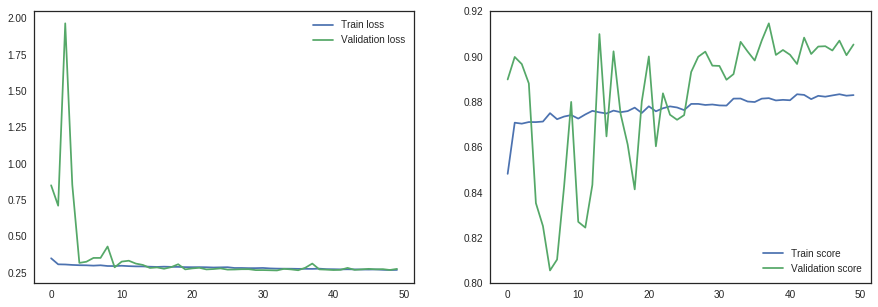

In [99]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["iou_loss_core"], label="Train score")
ax_score.plot(history.epoch, history.history["val_iou_loss_core"], label="Validation score")
ax_score.legend()

In [100]:
# predict

preds_test = model1.predict(train_df.images.map(upsample)[0].reshape(-1, img_size_target, img_size_target, 1))
preds_test.shape

(1, 101, 101, 1)

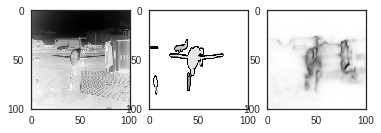

In [102]:
plt.subplot(1, 3, 1)
plt.imshow(train_df.images.map(upsample)[0])

plt.subplot(1, 3, 2)
plt.imshow(train_df.masks.map(upsample)[0])

plt.subplot(1, 3, 3)
plt.imshow(preds_test.reshape(101, 101))